In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error
import torch
from torch import nn
from torch.optim import RMSprop,SGD
torch.manual_seed(0)

###Other one

In [ ]:
# -*- coding: utf-8 -*-
"""

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from sklearn.metrics import mean_squared_error as mse

dta = pd.read_csv('/content/drive/My Drive/econ/arima_ann/data/wheat_1950-2017.csv', parse_dates = ['year'], index_col = ['year'])

dta.plot(figsize=(8,8))
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


#split into test and train
percentage = 0.6
series = dta['yield'].tolist()
size = int(len(series) * 0.66)  # @siva, THE PERSON TOOK ~21 YEARS FOR TEST, EHILE IN PAPER, THEY HAVE CONSIDERED ONLY LAST 10 YEARS
train, test = series[0:size], series[size:len(series)]
model = ARIMA(train , order = (2,1,0))
model_fit = model.fit()


from statsmodels.tsa.stattools import acf, pacf
acf_1 = acf(series)[1:20]
plt.plot(acf_1)
test_df = pd.DataFrame([acf_1]).T
test_df.columns = ["Pandas Autocorrelation"]
test_df.index += 1
test_df.plot(kind='bar')
pacf_1 = pacf(series)[1:20]
plt.plot(pacf_1)
plt.show()
test_df = pd.DataFrame([pacf_1]).T
test_df.columns = ['Pandas Partial Autocorrelation']
test_df.index += 1
test_df.plot(kind='bar')



from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.recurrent import LSTM


"""
Arima Rolling Forecast
"""
predicted1, resid_test = [], []
history = train
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    resid_test.append(test[t] - output[0])
    predicted1.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
test_resid = []
for i in resid_test:
    test_resid.append(i[0])
error = mean_squared_error(test, predicted1)
print('Test MSE: %.3f' % error)
plt.plot(test)
plt.plot(predicted1, color='red')
plt.show()



"""
Residual Diagnostics
"""
train, test = series[0:size], series[size:len(series)]
model = ARIMA(train, order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())
#plot the acf for the residuals
acf_1 = acf(model_fit.resid)[1:20]
plt.plot(acf_1)
test_df = pd.DataFrame([acf_1]).T
test_df.columns = ["Pandas Autocorrelation"]
test_df.index += 1
test_df.plot(kind='bar')
#from the acf obtained from the residuals we concule that 
#there is still a nonlinear relationship among the residuals




"""
Hybrid Model
"""


from keras.models import load_model
from keras.models import Model
window_size = 1
def make_model(window_size):
    model = Sequential()
    model.add(Dense(1, input_dim=window_size,
    activation="sigmoid"))
    model.add(Dense(20, activation="sigmoid"))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
#//@siva removing init as https://stackoverflow.com/questions/59092788/typeerror-keyword-argument-not-understood-init-in-classifier-add says so ! , init="uniform"

model = make_model(1)
#lstm_model = make_lstm_model()
min_max_scaler = preprocessing.MinMaxScaler()
train = np.array(train).reshape(-1,1)
test=np.array(test).reshape(-1,1)
train_scaled = min_max_scaler.fit_transform(test) 

train_X,train_Y = [],[]
for i in range(0 , len(train_scaled) - window_size):
    train_X.append(train_scaled[i:i+window_size])
    train_Y.append(train_scaled[i+window_size])

new_train_X,new_train_Y = [],[]
for i in train_X:
    new_train_X.append(i.reshape(-1))
for i in train_Y:
    new_train_Y.append(i.reshape(-1))
new_train_X = np.array(new_train_X)
new_train_Y = np.array(new_train_Y)
#new_train_X = np.reshape(new_train_X, (new_train_X.shape[0], new_train_X.shape[1], 1))
model.fit(new_train_X,new_train_Y, epochs=1500, batch_size=512, validation_split = .05) #@siva reomved nb_epoch to epochs





test_extended = train.tolist()[-1*window_size:] + test_resid
test_data = []
for i in test_extended:
    try:
        test_data.append(i[0])
    except:
        test_data.append(i)
test_data = np.array(test_data).reshape(-1,1)
min_max_scaler = preprocessing.MinMaxScaler()
test_scaled = min_max_scaler.fit_transform(test_data)
test_X,test_Y = [],[]
for i in range(0 , len(test_scaled) - window_size):
    test_X.append(test_scaled[i:i+window_size])
    test_Y.append(test_scaled[i+window_size])
    new_test_X,new_test_Y = [],[]
for i in test_X:
    new_test_X.append(i.reshape(-1))
for i in test_Y:
    new_test_Y.append(i.reshape(-1))
new_test_X = np.array(new_test_X)
new_test_Y = np.array(new_test_Y)
#new_test_X = np.reshape(new_test_X, (new_test_X.shape[0], new_test_X.shape[1], 1))
predictions = model.predict(new_train_X)
predictions_rescaled=min_max_scaler.inverse_transform(predictions)
Y = pd.DataFrame(new_train_Y)
pred = pd.DataFrame(predictions)
plt.plot(Y)
plt.plot(pred , color = 'r',label='predicted non linear part')
plt.xlabel('years')
plt.ylabel('yield')
plt.title('EXPEXTED VS PREDICTED(NON-LINEAR PART)')
#p.plot()
plt.show()


'''error = mse(test_resid,predictions_rescaled)
print('Test MSE: %.3f' % error)'''


df1=pd.DataFrame(predicted1)
df1=df1.iloc[:-1]

pred_final = predictions_rescaled + df1;
df2=pd.DataFrame(test)
df2=df2.iloc[:-1]
error = mse(df2,pred_final)/100;
print('Test MSE: %.3f' % error)



Y = pd.DataFrame(test)
pred = pd.DataFrame(pred_final)
plt.plot(Y, color ='blue' , label = 'original')
plt.plot(pred , color = 'red', label= 'predicted')
plt.title('EXPEXTED VS PREDICTED(ARIMA-ANN HYBRID)')
plt.xlabel('test set set')
plt.ylabel('Yield')
plt.show()

# OK, the real problem is person followed this https://github.com/Kanav123/ArimaAnnHybrid/blob/master/ArimaAnnHybrid.ipynb, which only considered the main variables instead of ERRORS, SO
# THE GOOD RESULTS SHOWN BELOW(WHICH ARE BETTER THAN PAPER) WERE POSIBLE, OFCOURSE, ARIMA-ROLLING-FORECAST SEEMS AGAIN A BETTER OPTION FOR IMPROVEMENTS.


##Mine

In [ ]:
data = pd.read_csv('/content/drive/My Drive/econ/arima_ann/data/wheat_1950-2017.csv',index_col=0)
data

,area,production,yield,area_under_irrigation
year,,,,
1950-51,9.75,6.46,663,33.99
1951-52,9.47,6.18,653,35.76
1952-53,9.83,7.50,763,37.15
1953-54,10.68,8.02,750,36.16
1954-55,11.26,9.04,803,35
...,...,...,...,...
2013-14,30.47,95.85,3146,93.58
2014-15,31.47,86.53,2750,94.19
2015-16,30.42,92.29,3034,-


####Visualize

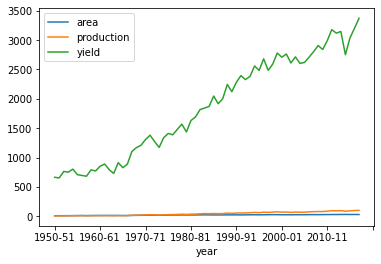

In [ ]:
data.plot()
# Remember, if there's trend  it is non-stationary.

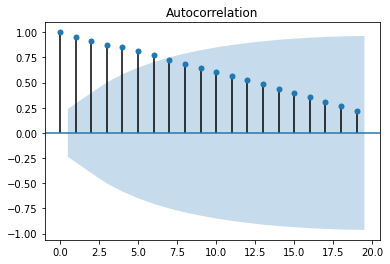

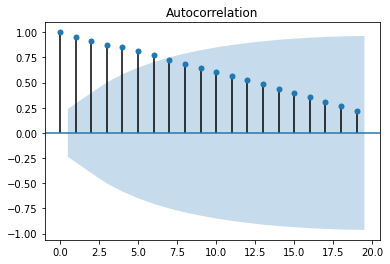

In [ ]:
plot_acf(data['yield'])
# Interpreting this: X-axis denotes lag of time(towards right) . when x=0, there;s no lag, So the correlation between x and x is 1. Now with lag=1, x1 = shift ervy value in x by 1. and now plot auto correlation b/w these.
# So in lag=1, you correlate x[0] with x[1] and in lag=5 corealte x[0] with x[5]  and so on. So if the auto corelation is high which means that there;s some correkation between x[0] and x[5] and so on..
# Naturally, it is expexted that with time , the correlation decreases. 
# So it proves that the data is not stationary. And in a stationary data, the auto correlation drops suddenly.

####So making it stationary

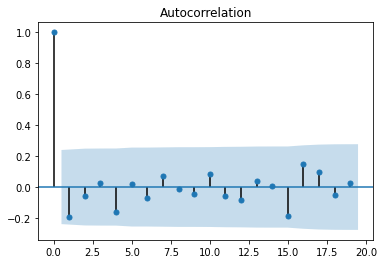

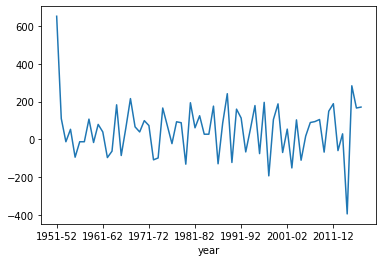

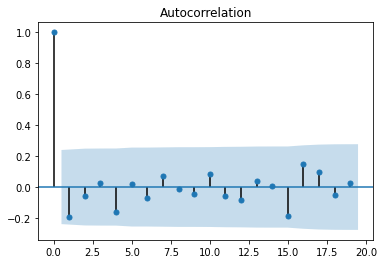

In [ ]:
yield_diff1 = data['yield'][1:].diff(periods=1).fillna(data['yield'])    # can remove fillna by [1:] in yield_diff
yield_diff1.plot()
plot_acf(yield_diff1)
# Integrated of order-1(d=1)
# Ok, after the first differencing, it becomes fairly stationary(except or the 2 peaks at beginning and end) . Mean,var laso seems statinary 

####DataSplit

In [ ]:
#according to paper #And you can change the data value of last in test to 3075 as it is in the paper
train = data['yield'][:54] #54
test = data['yield'][54:-4] #10
# print(train.tail())
print(test.tail())
print(len(test))
# Ok, you do differencing just to find d , and your train and test stll contain the calues of main data only

year
2009-10    2839
2010-11    2988
2011-12    3177
2012-13    3117
2013-14    3146
Name: yield, dtype: int64
10


###ARIMA

####Modelling

In [ ]:
arima_model = ARIMA(train,order=(2,1,0))    #according to paper !
#order : pass in parameters, (p,d,q) where d is the order of differencing you have done, p is the number of past periods you consider for the auto-regressive model(AR), q is the number of past periods you consider for the moving-average model(MA).
# 
fitted_model = arima_model.fit(disp=0)
predict = fitted_model.forecast(steps=10) #steps=how many next values you want to predict 
# predict = fitted_model.predict(start=54,end=64)
plt.plot(predict[0],color='red',label='predicted')    #predict[0] contains the predictions
plt.plot(test,color='green',label='actual')
plt.legend(loc='upper left')
plt.show()
predictions=predict[0]  
predictions
print(fitted_model.aic)
#  can use print(fitted_model.summary())
# With forecast() : Prediction is done in the levels of the original endogenous variable. If you would like prediction of differences in levels use predict
# https://i.stack.imgur.com/LKuBM.png also shows that there's differnce b/w predict and forecast()
# fitted_model.params

Finally

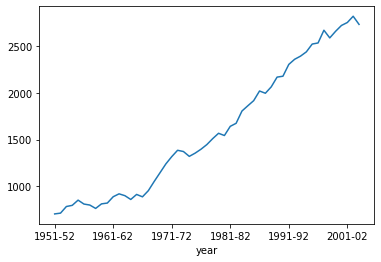

In [ ]:
# assert(all(fitted_model.predict(dynamic=False))==all(fitted_model.fittedvalues))    #tHEY BOTH ARE SAME 
# fitted_model.plot_predict(dynamic=False)
# plt.show()
fitted_model.predict(dynamic=False,typ='levels').plot()

* Compared these predicted values to the values given in the paper:There's just a little diference in each element(may be bcoz python!=sas) and fine overall

####Evaluation of the Model

In [ ]:
def mape(true,pred):
  sum = 0
  assert(len(true)==len(pred))
  for i in range(len(true)):
    val=abs(true[i]-pred[i])
    val = val/true[i]
    sum+=val
  return (sum/len(true))*100
# / for float division and // for integer diision in python

In [ ]:
mape([1,3,3],[9,10,11])

8.0
2.3333333333333335
2.6666666666666665


433.3333333333333

In [ ]:
mse  = mean_squared_error(test,predictions)
mapee =  mape(test,predictions)
print(mse)
print(mapee)
# assert(mean_squared_error(test,predictions)==mean_squared_error(predictions,test)) # they are same

11676.880204108427
3.1761937158493634


* FOR ARIMA
* According to paper mse  = 11686.41 and according to our results = 11676.880204108427
* According to paper, mape = 3.18 and according to our results = 3.1761937

####Find the best parameters

In [ ]:
import warnings
import sys
warnings.filterwarnings('ignore')
import itertools
p=d=q = range(0,21) # 0...5 for each
pdq = list(itertools.product(p,d,q))  # 125 cominations for 5
type(pdq[0])# is a tuple

best_aic = sys.maxsize  #Its like cpp's INT_MAX
best_params = (0,0,0)
for params in pdq:
  try:    #bcoz all cobinations of p,d,q are not valid. (You cant certainly go beyond a certain range)
    arima_model = ARIMA(train,order=params)
    fitted_model = arima_model.fit()
    if(fitted_model.aic<best_aic):
      best_aic = fitted_model.aic
      best_params = params
      print(best_params,best_aic)
  except Exception as e:
    pass
  
print(best_params,best_aic)

(0, 0, 0) 866.4198646953794
(0, 0, 1) 807.7778490587386
(0, 0, 2) 775.1738399704511
(0, 0, 3) 753.8852059983686
(0, 0, 4) 730.7605766685023
(0, 0, 5) 722.3189357107425
(0, 0, 6) 716.2212909850132
(0, 0, 7) 710.7667077153217
(0, 1, 0) 650.3425483371778
(0, 1, 1) 641.4698077915561
(1, 2, 1) 639.1572634805111
(2, 2, 1) 636.8454725751974


* As per paper, they took (2,1,0) which has aic of 641.652418086394 here 
* But the best fitted model is (2,2,1) with aic of 636.8454725751974 and there are 3-4 params which has better aic than (2,1,0)

* The AIC will take each model and rank them from best to worst. The “best” model will be the one that neither under-fits nor over-fits.
* AIC = -2(log-likelihood) + 2K
    *  K is the number of model parameters (the number of variables in the model plus the intercept).
    *  Log-likelihood is a measure of model fit. The higher the number, the better the fit. This is usually obtained from statistical output.

###Get Residuals

In [ ]:
import itertools
import warnings
import numpy as np
warnings.filterwarnings('ignore')
arima_model = ARIMA(train,order=(2,1,0))    #according to paper !

fitted_model = arima_model.fit(disp=0)

fittedvalues = fitted_model.predict(dynamic=False,typ='levels')

actualvalues = train

residuals = (actualvalues - fittedvalues)[1:]    #1st ones is Nan

residualsdata =[ [[0 for i in range(5)],[0]] for k in range(len(residuals)-5)]

for i in range(5,len(residuals)): #len(residuals)
  residualsdata[i-5] = [[residuals[k] for k in range(i-5,i)],[residuals[i]]]
residualsdata = np.array(residualsdata)

for i in range(len(residualsdata)):
  residualsdata[i][0] = np.array(residualsdata[i][0])
  residualsdata[i][1] = np.array(residualsdata[i][1])

print(residualsdata[-1])
print(residuals[-6:])
print(residualsdata.shape)

[array([  -2.10406274,  114.76915829,  -17.81006811,    4.73990243,
       -214.63451355])
 array([-24.19187709])]
year
1998-99     -2.104063
1999-00    114.769158
2000-01    -17.810068
2001-02      4.739902
2002-03   -214.634514
2003-04    -24.191877
dtype: float64
(48, 2)


####Modelling ANN/WNN

In [ ]:



# define wavelet activation . As you are using pytorch funcs, no need of defining backward function (bcoz they have autograd wit them) and it dont have any learnable params also
def wavelet(x):
  return torch.mul(torch.exp( -1* torch.square(x)), torch.cos(5*x))

class ANN(nn.Module):
  def __init__(self,iswnn):
    super(ANN,self).__init__()
    self.layer1numnodes = 5
    self.layer2numnodes = 3
    self.fc1 = nn.Linear(self.layer1numnodes,self.layer2numnodes,bias=True) #is this ok with arch as in paper !? or did he meant 5,3 & 3,3 & 3,1 ?
    self.fc2 = nn.Linear(self.layer2numnodes,1,bias=True)
    # self.dup = nn.Linear(self.layer2numnodes,self.layer2numnodes,bias=True)   #WHEN you want to try (5,3,3,1)
    self.activation = nn.Sigmoid()
  def forward(self,x):
    x = self.fc1(x)
    # x = self.dup(x)
    if(iswnn):
      x  = wavelet(x)
    else:
      x = self.activation(x)    #according to paper, activation is in hidden layer, not the last layer(ofcourse putting in last layer makes it tough to get a numebrocal value>1)
    x = self.fc2(x)
    
    return x
def trainModel(resids,num_iters,learning_rate,momentum,iswnn):
  model = ANN(iswnn)
  model = model.double()
  model.train()

  loss_func = nn.MSELoss()
  opt = RMSprop(model.parameters(),lr=learning_rate,momentum=momentum)
  for i in range(num_iters):
    iterloss=0
    for x,y in resids:
      # print(x,y)
      x = torch.from_numpy(x).double()
      y = torch.from_numpy(y)
      ypred =  model(x).reshape(shape=(1,1))
      loss = loss_func(ypred[0],y[0])
      iterloss += loss.data
      loss.backward()
      opt.step()
      opt.zero_grad()
    print("Epoch {}/{} \n Training: loss: {} ".format(i+1,num_iters,iterloss))
  
  return model  #trained model is returned for evaluation later 

#####Training the model

In [ ]:
iswnn = False#True  #False

# constants as per paper

learning_rate = 0.04
momentum = 0.02
num_iters = 1500
model = trainModel(residualsdata,num_iters,learning_rate,momentum,iswnn)

Epoch 1/1500 
 Training: loss: 455675.24457179185 
Epoch 2/1500 
 Training: loss: 453802.48312308715 
Epoch 3/1500 
 Training: loss: 454277.45118914254 
Epoch 4/1500 
 Training: loss: 453824.56843678566 
Epoch 5/1500 
 Training: loss: 452975.96629154636 
Epoch 6/1500 
 Training: loss: 452711.4740506219 
Epoch 7/1500 
 Training: loss: 452412.6958050106 
Epoch 8/1500 
 Training: loss: 452142.25715840975 
Epoch 9/1500 
 Training: loss: 451893.3604566057 
Epoch 10/1500 
 Training: loss: 451661.8660352562 
Epoch 11/1500 
 Training: loss: 451445.0305939925 
Epoch 12/1500 
 Training: loss: 451240.9035336841 
Epoch 13/1500 
 Training: loss: 451048.01190674916 
Epoch 14/1500 
 Training: loss: 450865.1860955558 
Epoch 15/1500 
 Training: loss: 450691.45953403617 
Epoch 16/1500 
 Training: loss: 450526.0091726525 
Epoch 17/1500 
 Training: loss: 450368.1182007338 
Epoch 18/1500 
 Training: loss: 450217.15569974226 
Epoch 19/1500 
 Training: loss: 450261.04400175245 
Epoch 20/1500 
 Training: loss

####Arima+Ann/WNN Validation

2602


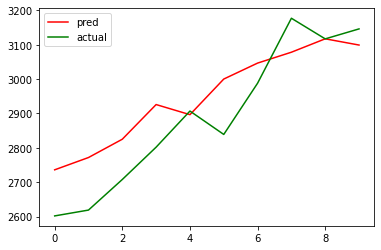

In [ ]:
# 1. Get residua;s for test data
#2. Append lasy 5 residuals of train data to the above residuals
#3. Convert them into desired format
#4. uSing these predict from ANN
#5. Add the predicted residuals to linear part and evaluate the model

#1
test = data['yield'][54:-4]
print(test[0])

arima_model = ARIMA(train,order=(2,1,0))
fitted_model = arima_model.fit(disp=0)
predict = fitted_model.forecast(steps=10)[0]

valresiduals = list(test - predict)

#2 
lasttrainresiduals = list(residuals[-5:])
lasttrainresiduals.extend(valresiduals)   #append appends the entore array and extend just adds the values

testandlasttrainresiduals = lasttrainresiduals
testandlasttrainresiduals

#3

valresidualsdata =[ [[0 for i in range(5)],[0]] for k in range(len(testandlasttrainresiduals)-5)]

for i in range(5,len(testandlasttrainresiduals)):
  valresidualsdata[i-5] = [[testandlasttrainresiduals[k] for k in range(i-5,i)],[testandlasttrainresiduals[i]]]
valresidualsdata = np.array(valresidualsdata)

for i in range(len(valresidualsdata)):  #converting list to arrays(ease of doin later)
  valresidualsdata[i][0] = np.array(valresidualsdata[i][0])
  valresidualsdata[i][1] = np.array(valresidualsdata[i][1])

valresidualsdata.shape # is (10,2)

#4
residualpredictions  = [] 
with torch.no_grad():
  model.eval()
  for x,y in valresidualsdata:
    x = torch.from_numpy(x).double()
    ypred =  model(x).reshape(shape=(1,1))
    residualpredictions.append(ypred[0].item())
residualpredictions

#5                  linearpart   + non-linearpart
arima_ann_test_results = predict + residualpredictions

#6 Plot the results w.r.t actual
plt.plot(arima_ann_test_results,label='pred',color='red')
plt.plot(list(test),label='actual',color='green')
plt.legend(loc='upper left')
plt.show()


####Evaluate Arima+ANN/WNN

In [ ]:
def mape(true,pred):
  sum = 0
  assert(len(true)==len(pred))
  for i in range(len(true)):
    val=abs(true[i]-pred[i])
    val = val/true[i]
    sum+=val
  return (sum/len(true))*100

In [ ]:
mse  = mean_squared_error(test,arima_ann_test_results)
mapee =  mape(test,arima_ann_test_results)
print(mse)
print(mapee)

11188.354961884545
3.2339783788585583


####Thoughts

In [ ]:
# From original data, there's a clear upward trend in yield, SO the data is non-stationary
# There are a variety of arima models, can try out them.
# ok, waht you get different constant losses with and without x =x.double()(more with double)

# A sample of constant loss: Epoch 1498/1500 
      #  Training: loss: 509282.99684042257 
      # Epoch 1499/1500 
      #  Training: loss: 509282.99684042257 
      # Epoch 1500/1500 
      #  Training: loss: 509282.9968404225
# ok ,its fine , til now best seems lr=0.001 and mom = 0.02  with SGD
# may be change sgd to rmsprop or may be these resutls are good enough ? its better to check once 
# yES you're crrect rms prop gets best with  nums mom=0.02, lr=0.04

# learning_rate = 0.004 momentum = 0.02 rmsprop
# Epoch 1499/1500 
#  Training: loss: 389088.5870888733 
# Epoch 1500/1500 
#  Training: loss: 389059.8467105883 

# # learning_rate = 0.04 momentum = 0.02 rmsprop as per paper and surely the loss is increasing sometimes which may be indicate that loss is too high
# Epoch 1499/1500 
#  Training: loss: 403251.79719351674 
# Epoch 1500/1500 
#  Training: loss: 403251.5958166119

# with their hyps + model of (5,3,1) get 9132.489926002005 and 2.86245632461385 but the paper has 6757.90, 2.50 .
#  So is there something wong with ANn model ? May be try with (5,3,3,1) ? \


# with (5,3,3,1) and above params 11876.491585695308 3.248376683661215. SO FURTHER BAD RESULTS 
# Epoch 1499/1500 
#  Training: loss: 442791.8680123013 
# Epoch 1500/1500 
#  Training: loss: 442789.4023011412

#  with author hyps and wnn , the loss is not at all decreasing(very less dec initially ). Any problem with learning ? 
    """
    Training: loss: 454339.33724832674 
    Epoch 1498/1500 
    Training: loss: 454339.33724832674 
    Epoch 1499/1500 
    Training: loss: 454339.3372483266 
    Epoch 1500/1500 
    Training: loss: 454339.3372483267 
    """


###Learnings

In [ ]:
# Never thought that ploting is so easy: df.plot()
# The saviour link https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ 
# A big learning:Peek into the arguments of thing: You were getting differenced values with predict bcoz default was typ='linear' but if you simply set it to 'levels', you get whatever you want
# Your model and inputs shoud have same dtype so do model = mode.double() as shown in https://discuss.pytorch.org/t/runtimeerror-expected-object-of-scalar-type-double-but-got-scalar-type-float-for-argument-2-weight/38961/9
# When you have only one item in tensor use var.item() to get the value of item https://discuss.pytorch.org/t/get-value-out-of-torch-cuda-float-tensor/2539/7
# Defining custom activations https://stackoverflow.com/questions/55765234/pytorch-custom-activation-functions  https://towardsdatascience.com/extending-pytorch-with-custom-activation-functions-2d8b065ef2fa 
# just see the templat eof above :: If your new function is differentiable then just write it as a python function. If it has parameters, you can use nn.Module and you will need to implement the init and the forward for your function. If it is not differentiable, you will have to define the backward operation you want using the informations here


###CanDo

In [ ]:

# CAN TRY THIS ROLLING FORECAST FOR ARIMA https://github.com/Kanav123/ArimaAnnHybrid/blob/master/ArimaAnnHybrid.ipynb

####Trash Cells

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


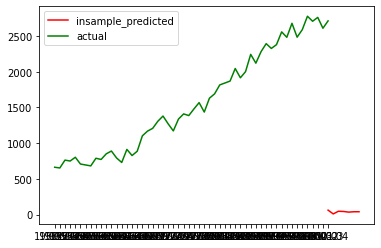

54


In [ ]:
insample_predictions = fitted_model.predict(start=54,end=60,dynamic=False)#set dynamic #start 0 is not working
type(insample_predictions)
plt.plot(insample_predictions,color='red',label='insample_predicted')
plt.plot(train,color='green',label='actual')
plt.legend(loc='upper left')
plt.show()
print(len(train))
# There's something wrong with predict,its'giving wrong results 